# **Прогнозирование прочности бетона**

# **1. Описание датасета и постановка задачи**

На прочность бетона влияют различные факторы, такие как используемые материалы, возраст и т.д.

Данный датасет дает возможность построить модели для прогноза прочности бетона на основе компонентов и других факторов в качестве предикторов.

Датасет содержит следующие признаки:

**CementComponent**: количество добавленного цемента.

**BlastFurnaceSlag**: количество добавленного шлака доменной печи.

**FlyAshComponent**: количество добавленного золы-уноса.

**WaterComponent**: количество добавленной воды.

**SuperplasticizerComponent**: количество добавленного суперпластификатора.

**CoarseAggregateComponent**: количество крупного заполнителя.

**FineAggregateComponent**: количество мелкого заполнителя.

**AgeInDays**: количество дней высыхания.

**Strength**: итоговая прочность бетона (целевая переменная).


# **2. Импорт библиотек и загрузка данных**

In [1]:
#!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [2]:
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1

In [3]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Машинное обучение (обучение и валидация)
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Предобработка данных
from sklearn.preprocessing import StandardScaler

# Регрессионные модели
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Метрики качества регрессии
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Оптимизация гиперпараметров
import optuna

# Интерпретируемость моделей
import shap

# Математические инструменты для построения интерполяции
from scipy.interpolate import interp1d

# Игнорируем предупреждения
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Загрузка данных
df = pd.read_csv('/content/Concrete.csv')

In [5]:
# Ознакомление с данными
print("Первые строки датасета:")
display(df.head())


Первые строки датасета:


,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [6]:
print(f"В исходном датасете {df.shape[1]} столбцов и {df.shape[0]} строк.")

В исходном датасете 10 столбцов и 5407 строк.


In [7]:
# Посмотрим основную информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 422.6 KB


Все признаки имеют числовой тип данных.

In [8]:
# Посмотрим основную информацию по целевой переменной Strength
df['Strength'].describe()

,Strength
count,5407.000000
mean,35.452071
std,16.401896
min,2.330000
25%,23.640000
50%,33.950000
75%,45.850000
max,82.600000


В нашем случае это задача **регрессии**.

# **3. Очистка и подготовка данных**

## **3.1. Обработка дубликатов**

In [9]:
# Проверим данные на наличие дубликатов
if df.duplicated().sum() == 0:
  print("Дубликаты отсутствуют")
else:
  print(f"В датасете {df.duplicated().sum()} строк с дубликатами.")

Дубликаты отсутствуют


## **3.2. Обработка пропущенных значений**

In [10]:
# Проверим колчиство пропущенных значений:
print("Количество пропущенных значений в каждой колонке:")
df.isnull().sum()

Количество пропущенных значений в каждой колонке:


,0
id,0
CementComponent,0
BlastFurnaceSlag,0
FlyAshComponent,0
WaterComponent,0
SuperplasticizerComponent,0
CoarseAggregateComponent,0
FineAggregateComponent,0
AgeInDays,0
Strength,0


Пропущенные значения отсутсвуют

## **3.3. Обработка аномалий и выбросов**

In [11]:
# Проведем статистический анализ числовых значений
df.drop(columns=['id']).describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


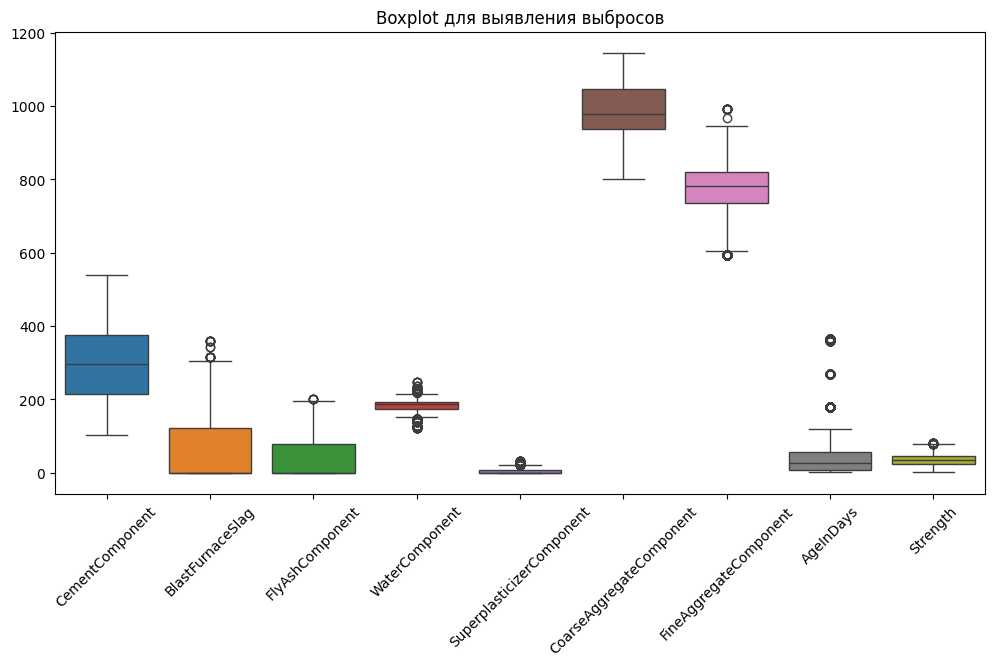

In [12]:
# Анализ выбросов с помощью boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=['id']))
plt.title("Boxplot для выявления выбросов")
plt.xticks(rotation=45)
plt.show()

На графиках видно, что у некоторых значений наблюдаются выбросы, однако стоит учесть, что это абсолютные значения компонентов и они зависят от объема выпущенной партии.

С целью расчета показателей прочности бетона необходимо расчитать относительные пропорции компонентов.


Видно, что на графиках BlastFurnaceSlag, FlyAshComponent, SuperplasticizerComponent отсутсвует медиана и нижний квартиль. Это говорит о том, что у большинства проб эти компоненты отсутствуют.

## **3.4. Группировка данных и создание новых признаков**

### **3.4.1. Учет времени твердения**

Процесс набора прочности бетона напрямую зависит от времени твердения, так как гидратация цемента продолжается в течение длительного периода, постепенно увеличивая прочность материала.

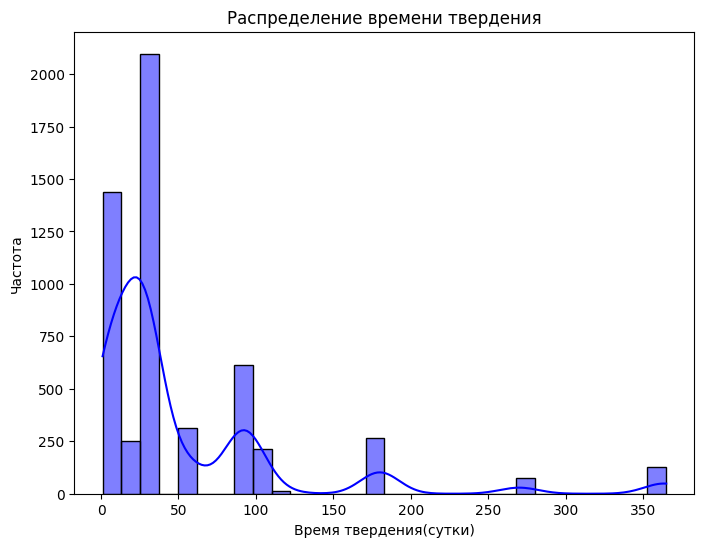

In [13]:
# Посмотрим на распределение времени твердения бетона
plt.figure(figsize=(8, 6))
sns.histplot(df['AgeInDays'], kde=True, bins=30, color='blue')
plt.title("Распределение времени твердения")
plt.xlabel("Время твердения(сутки)")
plt.ylabel("Частота")
plt.show()

Видно, что большинство проб было взято на 28 сутки (время, когда бетон должен набрать 100% проектной прочности)

Стоит обратить внимание, что набор прочности бетона происходит неравномерно.
В первые сутки после заливки бетон проходит интенсивную стадию твердения и набирает около 70% своей конечной прочности. Это связано с активной гидратацией цемента — химической реакцией между цементом и водой, при которой образуются прочные кристаллические структуры.

Однако после этого процесс значительно замедляется. Оставшиеся 30% прочности набираются в течение нескольких недель. Обычно для достижения 100% проектной прочности требуется 28 суток, но гидратация продолжается и дальше, особенно при благоприятных условиях (высокой влажности и температуре).

Ключевым в наборе прочности бетона также является температура окружающего возраста.

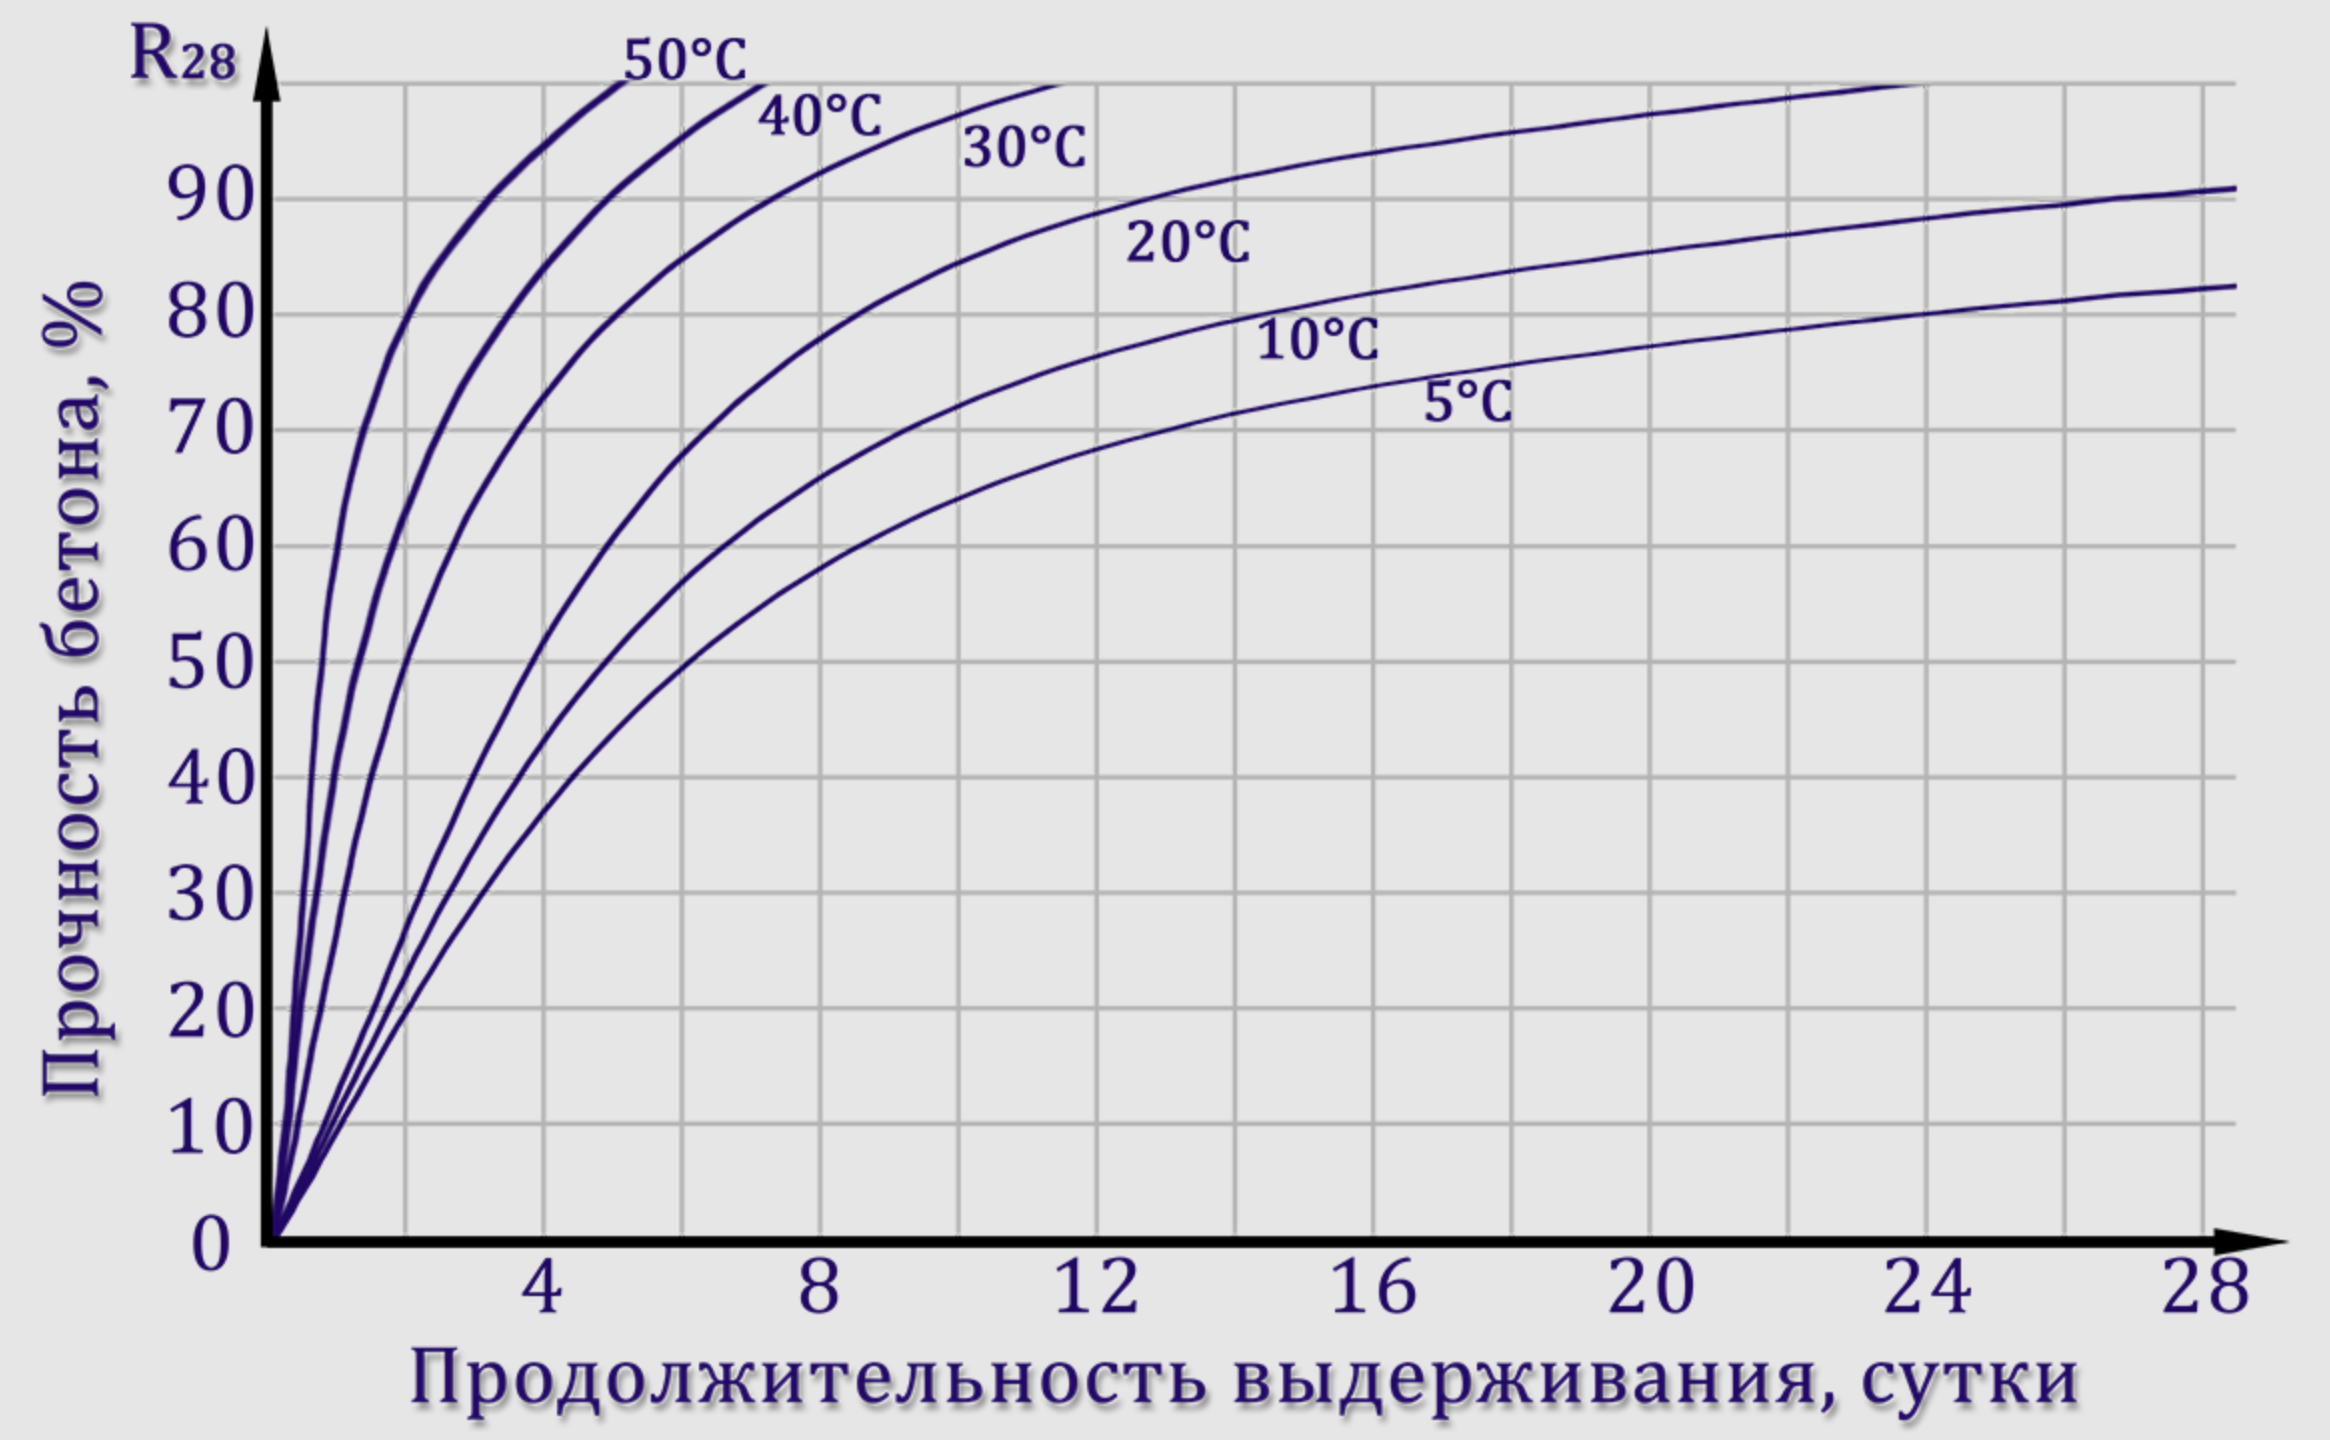

В представленных данных сведения о температуре, месте и времени отбора образцов отсутсвует, что не позволяет нам использовать очень важный показатель. Поэтому будем использовать усредненный график набора прочности бетона со среднесуточной температурой окружающего воздуха 20°C (либо с применением электропрогрева бетоннной смеси в зимний период)

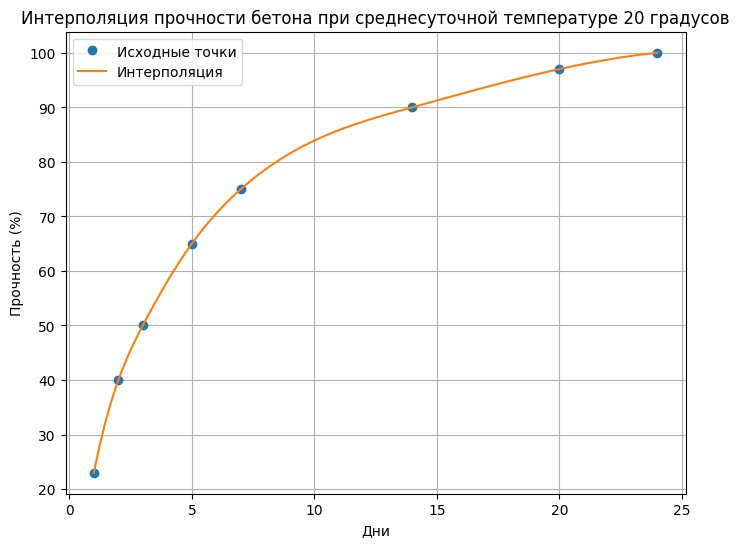

In [14]:
# Данные с графика для температуры 20°C
times = [1, 2, 3, 5, 7, 14, 20, 24]  # дни
strengths = [23, 40, 50, 65, 75, 90, 97, 100]  # проценты прочности

# Создание интерполяционной функции
interp_func = interp1d(times, strengths, kind='cubic')  # 'cubic' для полиномиальной интерполяции

# Временные точки для интерполяции
new_times = np.linspace(1, 24, 100)  # точки между 1 и 24 днями
new_strengths = interp_func(new_times)

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(times, strengths, 'o', label="Исходные точки")  # исходные данные
plt.plot(new_times, new_strengths, '-', label="Интерполяция")
plt.xlabel("Дни")
plt.ylabel("Прочность (%)")
plt.grid()
plt.title("Интерполяция прочности бетона при среднесуточной температуре 20 градусов")
plt.legend()
plt.show()

In [15]:
# Примененим интерполяцию к столбцу AgeInDays
df['PercentageOfStrength'] = df['AgeInDays'].apply(lambda x: interp_func(x)*0.01 if x <= 24 else (100 + (x)*20/90)*0.01)

# Просмотр обновленного датасета
display(df.head())

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,PercentageOfStrength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,0.500000
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1.062222
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1.062222
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1.811111
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1.200000


### **3.4.2. Учет соотношения**

Как уже было сказано ранее, важно не абсолютное значение объема компонентнов, а их соотношение.

Поэтому добавим новые признаки, которые будут отвечать за объем того или иного компонента относительного общего объема.

In [16]:
# Посчитаем общий компонентов для каждого образца
df['TotalComponent'] = df['CementComponent'] + df['BlastFurnaceSlag'] + df['FlyAshComponent'] + df['WaterComponent'] \
                        + df['SuperplasticizerComponent'] + df['CoarseAggregateComponent'] + df['FineAggregateComponent']

In [17]:
# Посчитаем процент воды
df['WaterRatio'] = df['WaterComponent'] / df['TotalComponent']

In [18]:
# Посчитаем процент вяжущих компонентов

df['CementRatio'] = (df['CementComponent'] + df['BlastFurnaceSlag'] + df['FlyAshComponent']) / df['TotalComponent']

In [19]:
# Просчитаем процент крупнозернистого заполнителя
df['CoarseAggregateRatio'] = df['CoarseAggregateComponent'] / df['TotalComponent']

In [20]:
# Просчитаем процент мелкозернистого заполнителя
df['FineAggregateRatio'] = df['FineAggregateComponent'] / df['TotalComponent']

In [21]:
# Просчитаем процент пластификаторов
df['SuperplasticizerRatio'] = df['SuperplasticizerComponent'] / df['TotalComponent']

In [22]:
# Просчитаем процент шлак от количества вяжущих компонентов
df['BlastFurnaceSlagRatio'] = df['BlastFurnaceSlag'] / (df['CementComponent'] + df['BlastFurnaceSlag'] + df['FlyAshComponent'])

In [23]:
# Просчитаем процент золы-уноса от количества вяжущих компонентов
df['FlyAshComponentRatio'] = df['FlyAshComponent'] / (df['CementComponent'] + df['BlastFurnaceSlag'] + df['FlyAshComponent'])

In [24]:
df

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,PercentageOfStrength,TotalComponent,WaterRatio,CementRatio,CoarseAggregateRatio,FineAggregateRatio,SuperplasticizerRatio,BlastFurnaceSlagRatio,FlyAshComponentRatio
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,0.500000,2449.0,0.075949,0.214373,0.459371,0.250306,0.000000,0.000000,0.000000
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1.062222,2264.0,0.084364,0.200972,0.427120,0.284011,0.003534,0.371429,0.314286
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1.062222,2479.7,0.074888,0.170867,0.433520,0.320724,0.000000,0.317914,0.000000
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1.811111,2210.0,0.103167,0.171946,0.421719,0.303167,0.000000,0.200000,0.000000
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1.200000,2301.6,0.083420,0.170751,0.406413,0.339416,0.000000,0.600509,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42,0.500000,2401.6,0.067455,0.228598,0.402648,0.296469,0.004830,0.043716,0.143898
5403,5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20,1.400000,2302.0,0.088184,0.152042,0.423110,0.336664,0.000000,0.000000,0.000000
5404,5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30,1.062222,2317.0,0.080147,0.127665,0.464480,0.327708,0.000000,0.000000,0.000000
5405,5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61,1.062222,2262.2,0.071877,0.207497,0.422509,0.293033,0.005084,0.198977,0.000000


## **3.5. Преобразование категориальных данных**

In [25]:
# Проверим наличие категориальных переменных в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
 10  PercentageOfStrength       5407 non-null   float64
 11  TotalComponent             5407 non-null   float64
 12  WaterRatio                 5407 non-null   float64
 13  CementRatio                5407 non-null   float

Категориальные переменные отсутсвуют

## **3.6. Изменение типов данных**

In [26]:
# Проверим корректность типов данных в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
 10  PercentageOfStrength       5407 non-null   float64
 11  TotalComponent             5407 non-null   float64
 12  WaterRatio                 5407 non-null   float64
 13  CementRatio                5407 non-null   float

Типы данных указаны корректно

# **4. Разведочный анализ данных**

## **4.1. Распределение целевой переменной**

In [27]:
# Посмотрим на статистические показатели прочности
df['Strength'].describe()

,Strength
count,5407.000000
mean,35.452071
std,16.401896
min,2.330000
25%,23.640000
50%,33.950000
75%,45.850000
max,82.600000


Аномальных значений не обнаружено, посмотрим на распределение

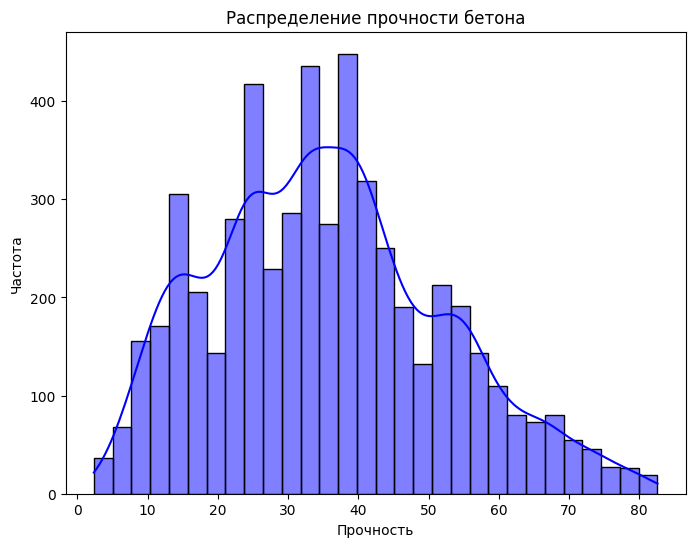

In [28]:
# Построим график распределения
plt.figure(figsize=(8, 6))
sns.histplot(df['Strength'], kde=True, bins=30, color='blue')
plt.title("Распределение прочности бетона")
plt.xlabel("Прочность")
plt.ylabel("Частота")
plt.show()

По графику распределения можно сказать следующее:

1. Распределение не является нормальным, так как имеет несколько пиков (мод). Это может указывать на смешанное распределение — скорее всего в выборке есть данные для разных типов бетона или различных условий твердения.

2. Основной диапазон прочности — от 10 до 60, но встречаются значения вплоть до 80.

3. Мода (пики частотности) — на 25-40. Это означает, что большинство образцов бетона имеет прочность в этом диапазоне.

4. Наблюдается правосторонняя асимметрия, что указывает на то, что есть небольшое количество образцов с очень высокой прочностью.


## **4.2. Распределение признаков**

Посмотрим на распределение основных признаков

### **4.2.1. Время твердения бетона**

In [29]:
# Посмотрим на статистические показатели времени твердения бетона
df['AgeInDays'].describe()

,AgeInDays
count,5407.000000
mean,51.751618
std,70.006975
min,1.000000
25%,7.000000
50%,28.000000
75%,56.000000
max,365.000000


Максимальное время твердения бетона 365 суток говорит о том, что аномалии отсутсвуют.

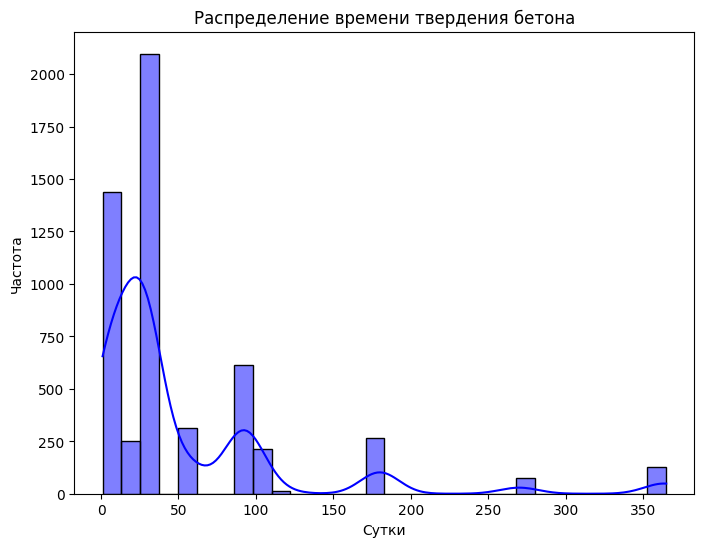

In [30]:
# Распределение времени твердения бетона (в сутках)
plt.figure(figsize=(8, 6))
sns.histplot(df['AgeInDays'], kde=True, bins=30, color='blue')
plt.title("Распределение времени твердения бетона")
plt.xlabel("Сутки")
plt.ylabel("Частота")
plt.show()

На графике видно, что распределение асимметрично (правосторонняя асимметрия). Большинство значений сосредоточено в диапазоне до 50 суток, после чего частота резко падает.
Есть небольшие пики около 100, 180, 270 и 350 суток.

Основной пик приходится на диапазон 0–50 суток, что логично, так как основные изменения прочности бетона происходят именно в этот период.
Пик на 28 сутках может указывать на стандартный срок, в течение которого бетон обычно достигает проектной прочности.

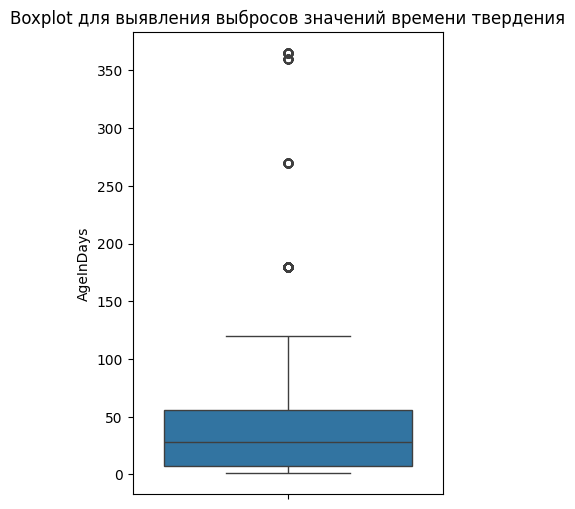

In [31]:
# Проверим данные на выбросы
plt.figure(figsize=(4, 6))
sns.boxplot(data=df['AgeInDays'])
plt.title("Boxplot для выявления выбросов значений времени твердения")
plt.show()

На графике видны выбросы. Посчитаем их количество.

In [32]:
# Вычисляем Q1 и Q3
Q1 = df['AgeInDays'].quantile(0.25)
Q3 = df['AgeInDays'].quantile(0.75)

# Межквартильный размах (IQR)
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
outliers = df[(df['AgeInDays'] < lower_bound) | (df['AgeInDays'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]
print(f"Количество выбросов: {num_outliers}")
print(f"Процентное соотношение выбросов от всего датасета: {round(num_outliers/df.shape[0]*100,2)}%")


Количество выбросов: 467
Процентное соотношение выбросов от всего датасета: 8.64%


Количество выбросов велико, поэтому не будем их удалять. Кроме того, важно оставить данные для образцов бетона годичного возраста.

### **4.2.2. Соотношение компонентов**

Прочность бетона напрямую зависит от соотношения его компонентов – воды, цемента, заполнителей и добавок. Оптимальный баланс этих составляющих определяет механические характеристики и долговечность материала.

Например, для бетона марки М300 (один из самых распространённых вариантов) примерный состав:

**Цемент** (портландцемент М400 или М500) – 300-350 кг

**Песок** (мелкий заполнитель) – 600-750 кг

**Щебень** (крупный заполнитель) – 1100-1300 кг

**Вода** – 150-180 л (учитывается водоцементное отношение)

**Добавки** (пластификаторы, ускорители) – по необходимости


Соотношение цемента, песка и щебня часто используется в виде пропорции, например:

1 : 2 : 4 (цемент : песок : щебень) – распространённая классическая смесь.

1 : 1.5 : 3 – для повышенной прочности.

**Влияние компонентов на прочность**:

**Цемент** – главный связующий компонент, определяет прочность.

**Вода** – необходима для гидратации цемента, но избыток снижает прочность.

**Песок** – должен быть средней крупности, без примесей глины.

**Щебень** – выбирается по фракции: чем крупнее, тем выше прочность.

**Добавки** – могут улучшать прочность, морозостойкость, водонепроницаемость.


#### **4.2.2.1. Вода**

In [33]:
# Посмотрим на статистические показатели соотношения воды
df['WaterRatio'].describe()

,WaterRatio
count,5407.000000
mean,0.079241
std,0.009470
min,0.047485
25%,0.074203
50%,0.080170
75%,0.083784
max,0.114487


Процент воды в допустимой норме.

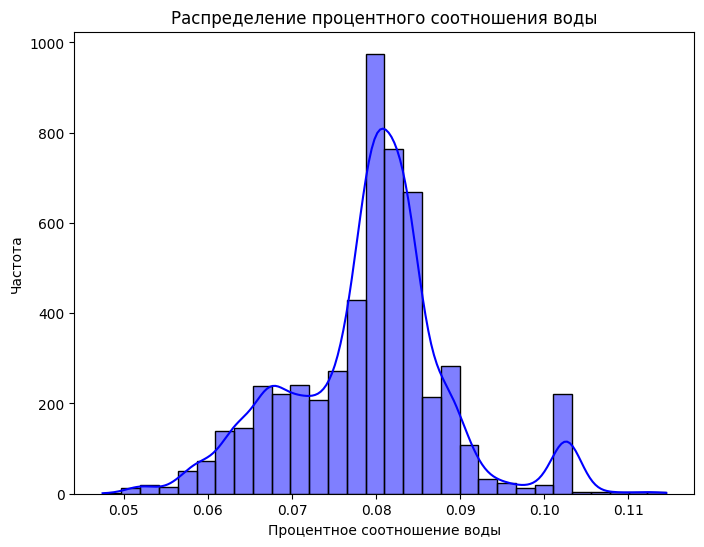

In [34]:
# Распределение процентного соотношения воды
plt.figure(figsize=(8, 6))
sns.histplot(df['WaterRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения воды")
plt.xlabel("Процентное соотношение воды")
plt.ylabel("Частота")
plt.show()

Распределение асимметрично, имеет смещение вправо. Основной пик наблюдается около 0.08 (8%), что является наиболее частым процентным соотношением воды.

Основное процентное содержание воды – около 8%.

Большинство значений укладываются в диапазон 6-9%, но есть редкие случаи выше 10%.

Избыток воды (10% и выше) может негативно сказаться на прочности бетона.

#### **4.2.2.2. Вяжущие**

В качестве вяжущих составляющих в образцах, представленных в датасете, применяется:

- цемент;

- гранулированный шлак;

- зола-уноса.



In [35]:
# Посмотрим на статистические показатели соотношения вяжущих
df['CementRatio'].describe()

,CementRatio
count,5407.000000
mean,0.165801
std,0.038923
min,0.048227
25%,0.140200
50%,0.158085
75%,0.200885
max,0.310456


В среднем количество вяжущих должно достигать 10-20% от общей массы бетонной смеси.

В данных наблюдаются как образцы с малым количеством вяжущих (4.8%), так и с большим (31%), что влияет на прочность бетонной смеси.

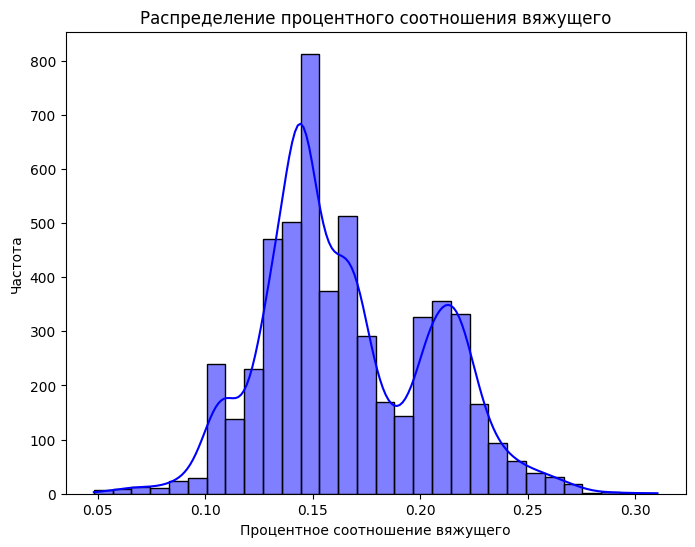

In [36]:
# Распределение процентного соотношения вяжущего
plt.figure(figsize=(8, 6))
sns.histplot(df['CementRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения вяжущего")
plt.xlabel("Процентное соотношение вяжущего")
plt.ylabel("Частота")
plt.show()

На графике видна двухмодальное распределение с двумя выраженными пиками:

Один около 15%

Второй около 20–22%. Данный пик может указывать на смеси с повышенным содержанием вяжущего, возможно, для высокопрочных бетонов.

Это говорит о возможном наличии двух разных групп данных (например, смеси с разными составами или марками бетона).


Большинство значений находится в пределах 10-22%.  
Небольшое количество значений выходит за пределы 5% и 30%, что можно рассматривать как выбросы.




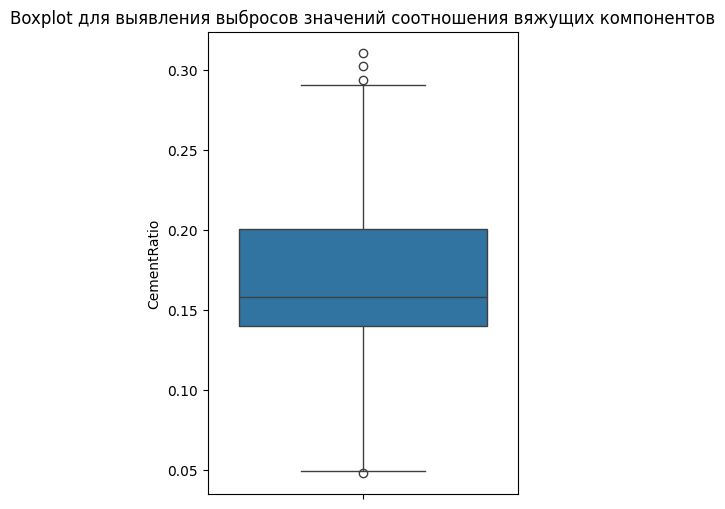

In [37]:
# Проверим данные на выбросы
plt.figure(figsize=(4, 6))
sns.boxplot(data=df['CementRatio'])
plt.title("Boxplot для выявления выбросов значений соотношения вяжущих компонентов")
plt.show()

График Boxplot указывает на выбросы. Посчитаем их количество.

In [38]:
# Вычисляем Q1 и Q3
Q1 = df['CementRatio'].quantile(0.25)
Q3 = df['CementRatio'].quantile(0.75)

# Межквартильный размах (IQR)
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
outliers = df[(df['CementRatio'] < lower_bound) | (df['CementRatio'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]
print(f"Количество выбросов: {num_outliers}")
print(f"Процентное соотношение выбросов от всего датасета: {round(num_outliers/df.shape[0]*100,2)}%")


Количество выбросов: 4
Процентное соотношение выбросов от всего датасета: 0.07%


Всего выявлено 4 выброса. Так как значение невелико, удалим строки с этими выбросами из датасета.

In [39]:
# Удаляем выбросы из исходного датасета
df = df[(df['CementRatio'] >= lower_bound) & (df['CementRatio'] <= upper_bound)]

# Проверяем размер очищенного датасета
print(f"Размер нового датасета: {df.shape}")

Размер нового датасета: (5403, 19)


#### **4.2.2.3. Крупный заполнитель**

In [40]:
# Посмотрим на статистические показатели соотношения крупного заполнителя
df['CoarseAggregateRatio'].describe()

,CoarseAggregateRatio
count,5403.000000
mean,0.423693
std,0.030289
min,0.319978
25%,0.406413
50%,0.424004
75%,0.444775
max,0.538020


Процент крупного заполнителя в бетонной смеси обычно составляет 40-50%.

Посмотрим на распределение.

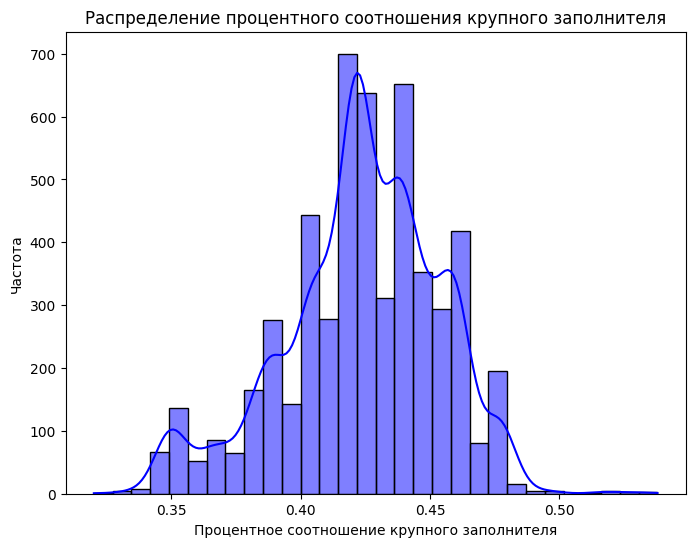

In [41]:
# Распределение процентного соотношения крупного заполнителя
plt.figure(figsize=(8, 6))
sns.histplot(df['CoarseAggregateRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения крупного заполнителя")
plt.xlabel("Процентное соотношение крупного заполнителя")
plt.ylabel("Частота")
plt.show()

Распределение близко к нормальному, но слегка правостороннее

Большинство значений сосредоточено между 40-45%.

Видно два выраженных максимума, что может указывать на различные типы бетонных смесей с разными пропорциями крупного заполнителя.
Один пик около 0.42, второй ближе к 0.44.

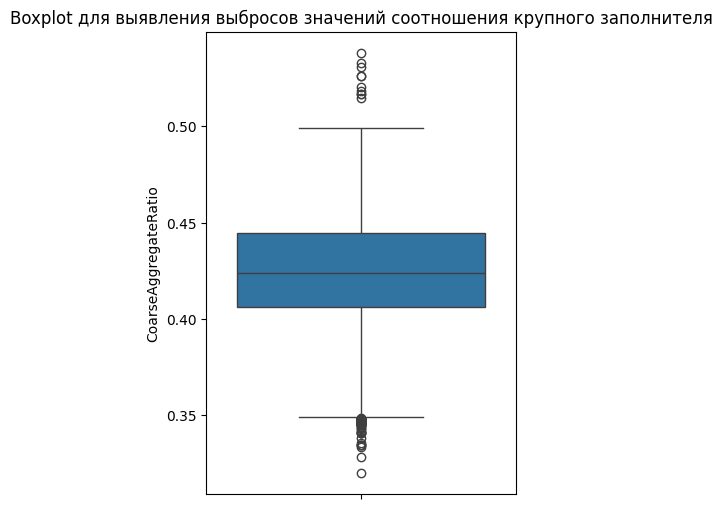

In [42]:
# Проверим данные на выбросы
plt.figure(figsize=(4, 6))
sns.boxplot(data=df['CoarseAggregateRatio'])
plt.title("Boxplot для выявления выбросов значений соотношения крупного заполнителя")
plt.show()

 График Boxplot указывает на выбросы. Посчитаем их количество.

In [43]:
# Вычисляем Q1 и Q3
Q1 = df['CoarseAggregateRatio'].quantile(0.25)
Q3 = df['CoarseAggregateRatio'].quantile(0.75)

# Межквартильный размах (IQR)
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
outliers = df[(df['CoarseAggregateRatio'] < lower_bound) | (df['CoarseAggregateRatio'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]
print(f"Количество выбросов: {num_outliers}")
print(f"Процентное соотношение выбросов от всего датасета: {round(num_outliers/df.shape[0]*100,2)}%")


Количество выбросов: 89
Процентное соотношение выбросов от всего датасета: 1.65%


Всего выявлено 89 выбросов. Так как значение невелико, удалим строки с этими выбросами из датасета.

In [44]:
# Удаляем выбросы из исходного датасета
df = df[(df['CoarseAggregateRatio'] >= lower_bound) & (df['CoarseAggregateRatio'] <= upper_bound)]

# Проверяем размер очищенного датасета
print(f"Размер нового датасета: {df.shape}")

Размер нового датасета: (5314, 19)


#### **4.2.2.4. Мелкий заполнитель**

In [45]:
# Посмотрим на статистические показатели соотношения мелкого заполнителя
df['FineAggregateRatio'].describe()

,FineAggregateRatio
count,5314.000000
mean,0.329345
std,0.034153
min,0.232373
25%,0.311461
50%,0.332484
75%,0.352547
max,0.433390


Процент мелкого заполнителя в бетонной смеси обычно составляет 25-40%.

Посмотрим на распределение.

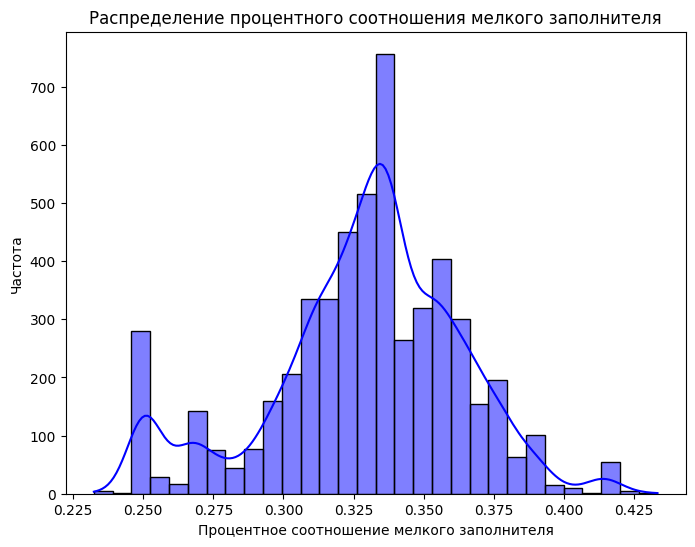

In [46]:
# Распределение процентного соотношения мелкого заполнителя
plt.figure(figsize=(8, 6))
sns.histplot(df['FineAggregateRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения мелкого заполнителя")
plt.xlabel("Процентное соотношение мелкого заполнителя")
plt.ylabel("Частота")
plt.show()

Распределение близко к нормальному, есть небольшое правостороннее смещение, но в целом распределение выглядит симметричным.

Большинство значений находятся в пределах 30-38%.

Основной пик около 33%, но есть дополнительный пик около 25%.
Это может указывать на использование разных типов бетонных смесей – одна группа с более высоким содержанием песка, другая с более низким.


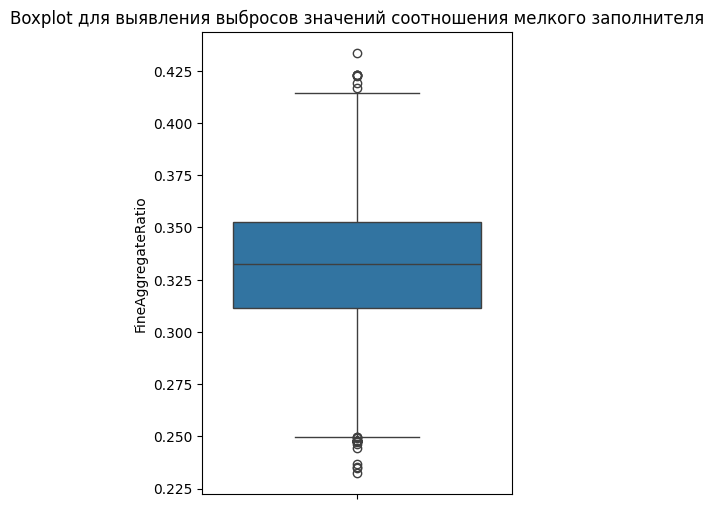

In [47]:
# Проверим данные на выбросы
plt.figure(figsize=(4, 6))
sns.boxplot(data=df['FineAggregateRatio'])
plt.title("Boxplot для выявления выбросов значений соотношения мелкого заполнителя")
plt.show()

 График Boxplot указывает на выбросы. Посчитаем их количество.

In [48]:
# Вычисляем Q1 и Q3
Q1 = df['FineAggregateRatio'].quantile(0.25)
Q3 = df['FineAggregateRatio'].quantile(0.75)

# Межквартильный размах (IQR)
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
outliers = df[(df['FineAggregateRatio'] < lower_bound) | (df['FineAggregateRatio'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]
print(f"Количество выбросов: {num_outliers}")
print(f"Процентное соотношение выбросов от всего датасета: {round(num_outliers/df.shape[0]*100,2)}%")


Количество выбросов: 39
Процентное соотношение выбросов от всего датасета: 0.73%


Всего выявлено 39 выбросов. Так как значение невелико, удалим строки с этими выбросами из датасета.

In [49]:
# Удаляем выбросы из исходного датасета
df = df[(df['FineAggregateRatio'] >= lower_bound) & (df['FineAggregateRatio'] <= upper_bound)]

# Проверяем размер очищенного датасета
print(f"Размер нового датасета: {df.shape}")

Размер нового датасета: (5275, 19)


#### **4.2.2.5. Добавки**

Для повышения прочности бетона, а также для улучшения его морозостойкости, водонепроницаемости, удобоукладываемости и других эксплуатационных характеристик, в состав смеси вводят различные химические и минеральные добавки.

Применение добавок позволяет не только повысить прочность, но и продлить срок службы бетонных конструкций, сделать их более устойчивыми к агрессивным условиям окружающей среды.

##### **4.2.2.5.1. Пластификатор**

**Пластификатор** – это химическая добавка, улучшающая свойства бетонной смеси. Основная цель пластификатора – повысить подвижность бетона (удобоукладываемость) без увеличения количества воды, а также улучшить прочностные характеристики.

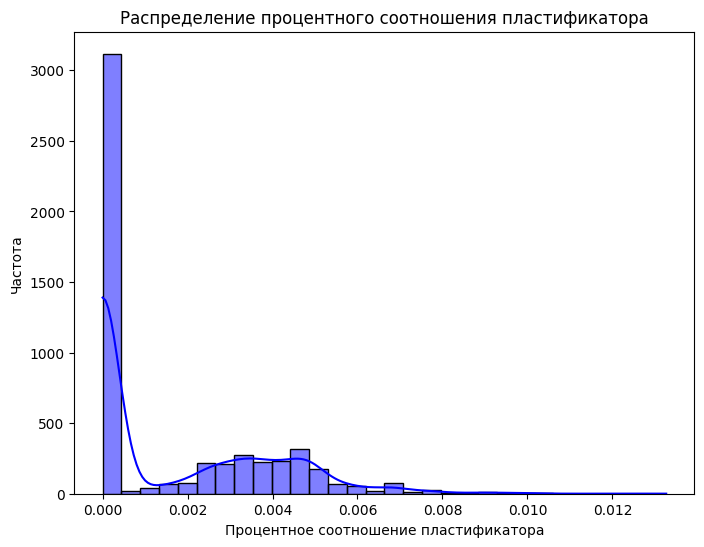

In [50]:
# Распределение процентного соотношения пластификатора
plt.figure(figsize=(8, 6))
sns.histplot(df['SuperplasticizerRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения пластификатора")
plt.xlabel("Процентное соотношение пластификатора")
plt.ylabel("Частота")
plt.show()

На графике видно, что абсолютное большинство образцов не имеют в своем составе пластификатор.

Посмотрим на распределение по образцам, у которых данная добавка присутсвует.

In [51]:
# Посмотрим на статистические показатели соотношения пластификатора по образцам, в составе которого он присутсвует
df[df['SuperplasticizerRatio'] != 0]['SuperplasticizerRatio'].describe()

,SuperplasticizerRatio
count,2157.000000
mean,0.003978
std,0.001577
min,0.000669
25%,0.002904
50%,0.003878
75%,0.004818
max,0.013267


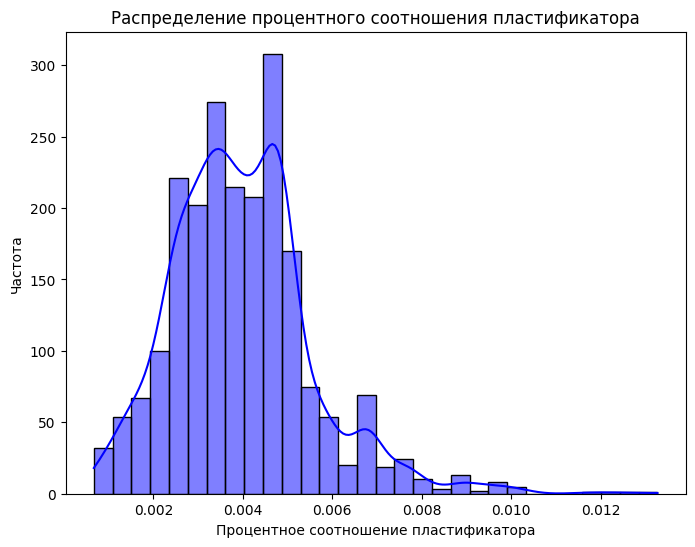

In [52]:
# Распределение процентного соотношения пластификатора по образцам, в составе которого он присутсвует
plt.figure(figsize=(8, 6))
sns.histplot(df[df['SuperplasticizerRatio'] != 0]['SuperplasticizerRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения пластификатора")
plt.xlabel("Процентное соотношение пластификатора")
plt.ylabel("Частота")
plt.show()

Распределение асимметрично (левый пик, длинный правый хвост)

Большинство смесей содержат до 0.6% пластификатора в своем составе.


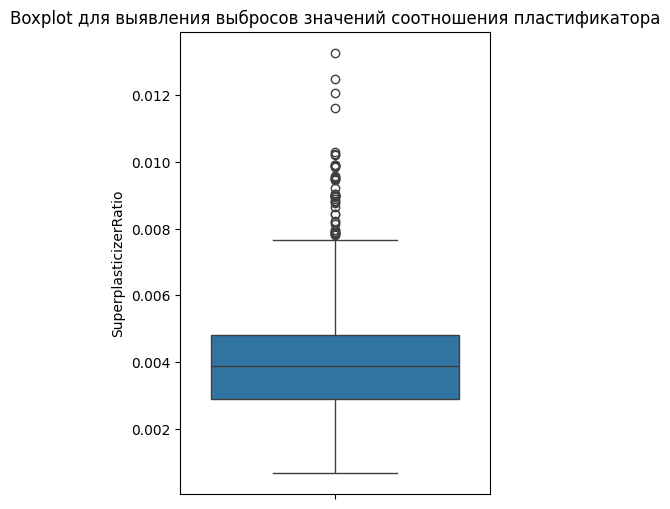

In [53]:
# Проверим данные на выбросы
plt.figure(figsize=(4, 6))
sns.boxplot(y=df[df['SuperplasticizerRatio'] != 0]['SuperplasticizerRatio'])
plt.title("Boxplot для выявления выбросов значений соотношения пластификатора")
plt.show()

 График Boxplot указывает на выбросы. Посчитаем их количество.

In [54]:
# Вычисляем Q1 и Q3
Q1 = df['SuperplasticizerRatio'].quantile(0.25)
Q3 = df['SuperplasticizerRatio'].quantile(0.75)

# Межквартильный размах (IQR)
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
outliers = df[(df['SuperplasticizerRatio'] < lower_bound) | (df['SuperplasticizerRatio'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]
print(f"Количество выбросов: {num_outliers}")
print(f"Процентное соотношение выбросов от образцов с данной добавкой: {round(num_outliers/df[df['SuperplasticizerRatio'] != 0]['SuperplasticizerRatio'].shape[0]*100,2)}%")


Количество выбросов: 32
Процентное соотношение выбросов от образцов с данной добавкой: 1.48%


Всего выявлено 32 выброса. Так как значение невелико, удалим строки с этими выбросами из датасета.

In [55]:
# Удаляем выбросы из исходного датасета
df = df[(df['SuperplasticizerRatio'] >= lower_bound) & (df['SuperplasticizerRatio'] <= upper_bound)]

# Проверяем размер очищенного датасета
print(f"Размер нового датасета: {df.shape}")

Размер нового датасета: (5243, 19)


##### **4.2.2.5.2. Гранулированный шлак**

**Гранулированный шлак** – это побочный продукт металлургической промышленности, который активно используется как минеральная добавка в бетоне. Его введение в состав смеси улучшает ряд характеристик бетона, в том числе и прочность.

Гранулированный шлак мы ранее учитывали в составе вяжущего, но также важно выделить этот признак отдельно.

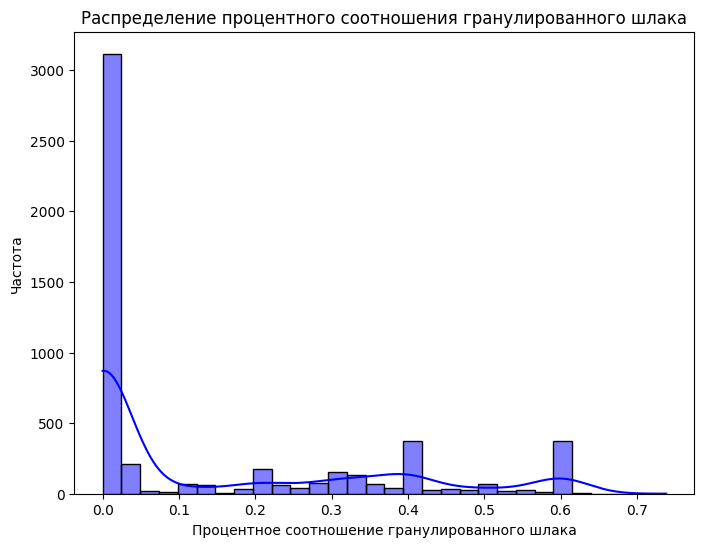

In [56]:
# Распределение процентного соотношения гранулированного шлака
plt.figure(figsize=(8, 6))
sns.histplot(df['BlastFurnaceSlagRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения гранулированного шлака")
plt.xlabel("Процентное соотношение гранулированного шлака")
plt.ylabel("Частота")
plt.show()

На графике видно, что абсолютное большинство образцов не имеют в своем составе гранулированный шлак.

Посмотрим на распределение по образцам, у которых данная добавка присутсвует.

In [57]:
# Посмотрим на статистические показатели соотношения гранулированного шлака по образцам, в составе которого он присутсвует
df[df['BlastFurnaceSlagRatio'] != 0]['BlastFurnaceSlagRatio'].describe()

,BlastFurnaceSlagRatio
count,2127.000000
mean,0.343412
std,0.177178
min,0.029880
25%,0.200075
50%,0.346853
75%,0.468854
max,0.738462


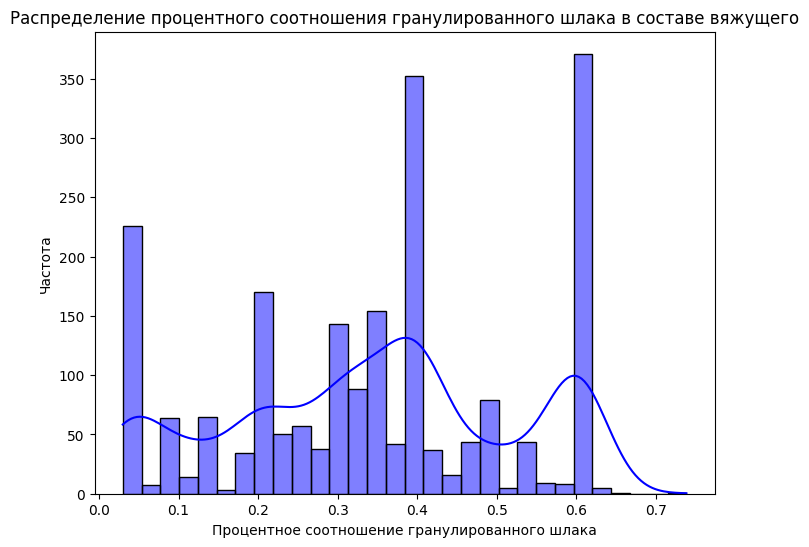

In [58]:
# Распределение процентного соотношения гранулированного шлака по образцам, в составе которого он присутсвует
plt.figure(figsize=(8, 6))
sns.histplot(df[df['BlastFurnaceSlagRatio'] != 0]['BlastFurnaceSlagRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения гранулированного шлака в составе вяжущего")
plt.xlabel("Процентное соотношение гранулированного шлака")
plt.ylabel("Частота")
plt.show()

Распределение дискретное, что говорит о наличии фиксированных рецептур бетона с определённым содержанием шлака.

Часто встречаются смеси с 40% и 60% шлака, что подтверждает стандартные дозировки в строительстве.

Редкие случаи выше 70% могут быть выбросами или специфическими смесями.

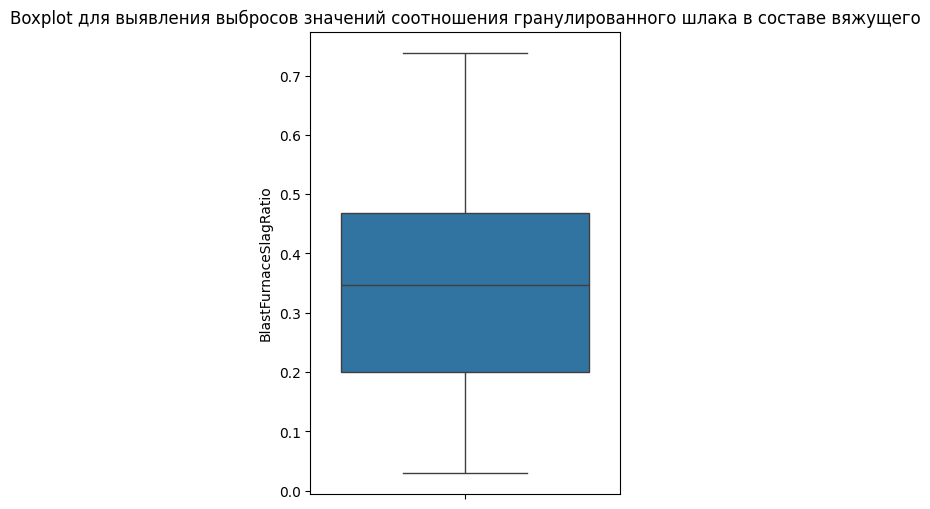

In [59]:
# Проверим данные на выбросы
plt.figure(figsize=(4, 6))
sns.boxplot(y=df[df['BlastFurnaceSlagRatio'] != 0]['BlastFurnaceSlagRatio'])
plt.title("Boxplot для выявления выбросов значений соотношения гранулированного шлака в составе вяжущего")
plt.show()

 Выбросы не обнаружены

##### **4.2.2.5.3. Зола-уноса**

**Зола-уноса** – это тонкодисперсный минеральный материал, получаемый как побочный продукт сгорания угля на тепловых электростанциях (ТЭС). Она активно используется в бетоне в качестве пуццолановой добавки, заменяя часть цемента.

Золу-уноса мы ранее учитывали в составе вяжущего, но также важно выделить этот признак отдельно.

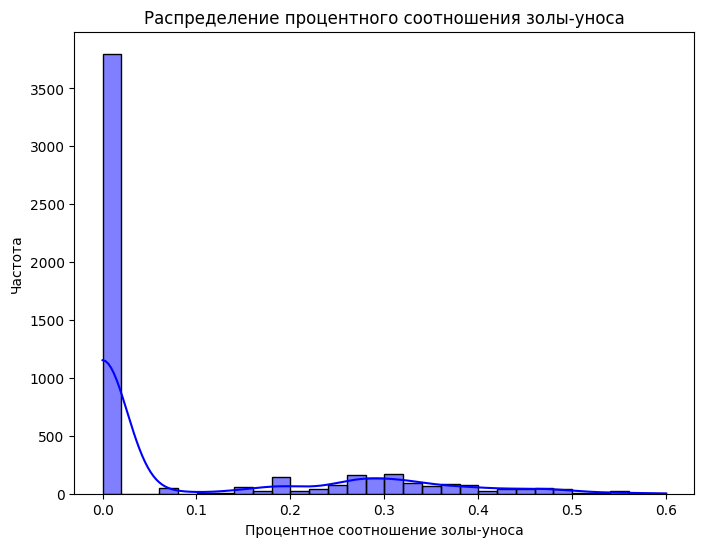

In [60]:
# Распределение процентного соотношения золы-уноса
plt.figure(figsize=(8, 6))
sns.histplot(df['FlyAshComponentRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения золы-уноса")
plt.xlabel("Процентное соотношение золы-уноса")
plt.ylabel("Частота")
plt.show()

На графике видно, что абсолютное большинство образцов не имеют в своем составе гранулированный шлак.

Посмотрим на распределение по образцам, у которых данная добавка присутсвует.

In [61]:
# Посмотрим на статистические показатели соотношения золы-уноса по образцам, в составе которого он присутсвует
df[df['FlyAshComponentRatio'] != 0]['FlyAshComponentRatio'].describe()

,FlyAshComponentRatio
count,1443.000000
mean,0.303085
std,0.104388
min,0.061327
25%,0.244314
50%,0.299251
75%,0.370162
max,0.600601


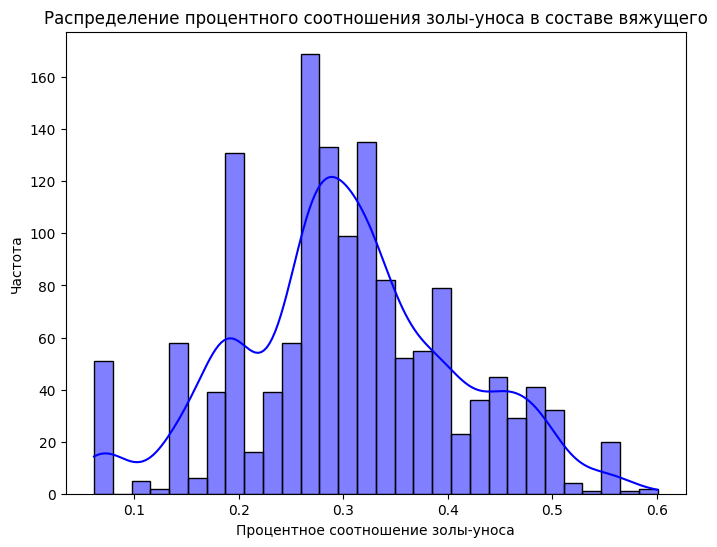

In [62]:
# Распределение процентного соотношения золы-уноса по образцам, в составе которого он присутсвует
plt.figure(figsize=(8, 6))
sns.histplot(df[df['FlyAshComponentRatio'] != 0]['FlyAshComponentRatio'], kde=True, bins=30, color='blue')
plt.title("Распределение процентного соотношения золы-уноса в составе вяжущего")
plt.xlabel("Процентное соотношение золы-уноса")
plt.ylabel("Частота")
plt.show()

Распределение асимметрично с длинным правым хвостом (правосторонняя асимметрия).

Большинство данных лежит в пределах 20-40% от вяжущего компонента.

Видно несколько подъемов в диапазоне 15%, 20% и 30%, что может указывать на разные стандартные рецептуры бетона с разным содержанием золы.



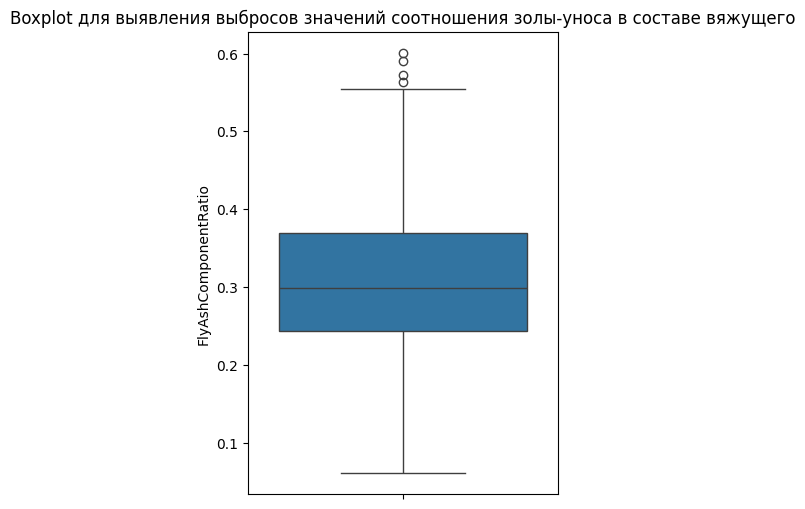

In [63]:
# Проверим данные на выбросы
plt.figure(figsize=(4, 6))
sns.boxplot(y=df[df['FlyAshComponentRatio'] != 0]['FlyAshComponentRatio'])
plt.title("Boxplot для выявления выбросов значений соотношения золы-уноса в составе вяжущего")
plt.show()

 График Boxplot указывает на выбросы. Посчитаем их количество.

In [64]:
# Вычисляем Q1 и Q3
Q1 = df['FlyAshComponentRatio'].quantile(0.25)
Q3 = df['FlyAshComponentRatio'].quantile(0.75)

# Межквартильный размах (IQR)
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
outliers = df[(df['FlyAshComponentRatio'] < lower_bound) | (df['FlyAshComponentRatio'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]
print(f"Количество выбросов: {num_outliers}")
print(f"Процентное соотношение выбросов от образцов с данной добавкой: {round(num_outliers/df[df['FlyAshComponentRatio'] != 0]['FlyAshComponentRatio'].shape[0]*100,2)}%")


Количество выбросов: 169
Процентное соотношение выбросов от образцов с данной добавкой: 11.71%


Всего обнаружено 169 выбросов. Достаточно большое количество (почти 12% от всех образцов с данной добавкой). Не будем удалять эти значения.

## **4.3. Матрица корреляции**

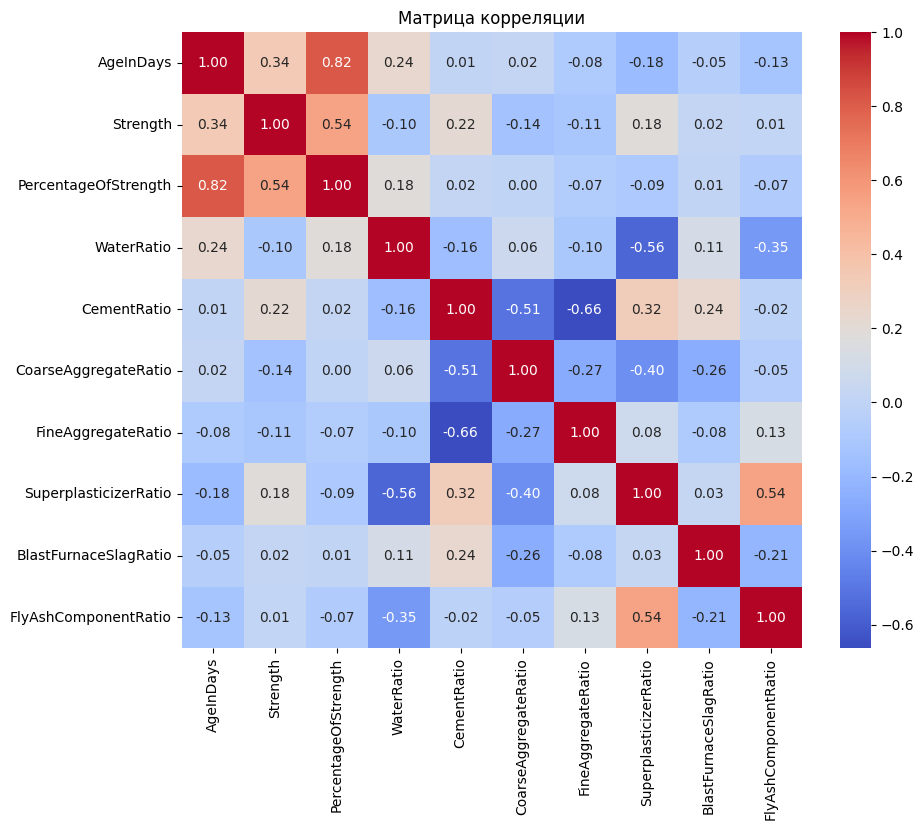

In [65]:
# Построим матрицу корреляции
plt.figure(figsize=(10, 8))
corr_matrix = df[['AgeInDays',
       'Strength', 'PercentageOfStrength', 'WaterRatio',
       'CementRatio', 'CoarseAggregateRatio', 'FineAggregateRatio',
       'SuperplasticizerRatio', 'BlastFurnaceSlagRatio',
       'FlyAshComponentRatio']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Матрица корреляции")
plt.show()

На графике видна сильная корреляция между сроком твердения и процентом твердения. Необходимо удалить один из столбцов во избежание мультиколлинеарности.

Сильная корреляция между вяжущими, мелким и крупным заполнителем объясняется рецептурными пропорциями.

# **5. Препроцессинг**

## **5.1. Понижение размерности**

In [66]:
# Удалим ненужные столбцы
df = df.drop(columns=['id', 'CementComponent', 'WaterComponent', 'CoarseAggregateComponent', 'FineAggregateComponent',
                       'SuperplasticizerComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'TotalComponent'])

In [67]:
# Также удалим столбец 'AgeInDays' во избежание мультиколлинеарности
df = df.drop('AgeInDays', axis=1)

In [68]:
# Ознакомление с данными
print("Первые строки измененного датасета:")
display(df.head())


Первые строки измененного датасета:


,Strength,PercentageOfStrength,WaterRatio,CementRatio,CoarseAggregateRatio,FineAggregateRatio,SuperplasticizerRatio,BlastFurnaceSlagRatio,FlyAshComponentRatio
0,10.38,0.500000,0.075949,0.214373,0.459371,0.250306,0.000000,0.000000,0.000000
1,23.52,1.062222,0.084364,0.200972,0.427120,0.284011,0.003534,0.371429,0.314286
2,36.96,1.062222,0.074888,0.170867,0.433520,0.320724,0.000000,0.317914,0.000000
3,39.05,1.811111,0.103167,0.171946,0.421719,0.303167,0.000000,0.200000,0.000000
4,74.19,1.200000,0.083420,0.170751,0.406413,0.339416,0.000000,0.600509,0.000000


In [69]:
print(f"В измененном датасете {df.shape[1]} столбцов и {df.shape[0]} строк.")

В измененном датасете 9 столбцов и 5243 строк.


## **5.2. Нормализация данных**

С целью нормализации данных выделим таргетное значение в отедльную переменную,  а также удалим этот столбец из датасета

In [70]:
# Выделяем таргет в отдельную переменную
y = df['Strength']

In [71]:
# Выделяем признаки в отельную переменную
X = df.drop('Strength', axis=1)

In [72]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 6. Выбор модели

In [73]:
# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# Создаём пустую таблицу для метрик
metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE'])

In [75]:
# Напишем функцию для выбора основной модели
def evaluate_model(model, X_train, y_train, X_test, y_test):

    global metrics_df

    # Обучение модели
    model.fit(X_train, y_train)

    # Прогнозирование
    y_pred = model.predict(X_test)

    # Оценка модели
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5

    # Вывод метрик
    print(f"Метрики качества для модели {type(model).__name__}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

        # Добавление метрик в сводную таблицу
    metrics_dict = {
        'Model': type(model).__name__,
        'MAE': mae,
        'RMSE': rmse,
    }

    # Добавляем метрики в таблицу
    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_dict])], ignore_index=True)

## **6.1. LinearRegression (Baseline)**

В качестве baseline возмем модель линейной регресии

In [76]:
lr_model = LinearRegression()
evaluate_model(lr_model, X_train, y_train, X_test, y_test)

Метрики качества для модели LinearRegression:
MAE: 9.6507
RMSE: 12.3374


## **6.2. ElasticNet**

In [77]:
en_model = ElasticNet(alpha=0.01, l1_ratio=0.8, random_state=42)
evaluate_model(en_model, X_train, y_train, X_test, y_test)

Метрики качества для модели ElasticNet:
MAE: 9.6517
RMSE: 12.3365


## **6.3. RandomForest**

In [78]:
rf_model =  RandomForestRegressor(random_state=42)
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

Метрики качества для модели RandomForestRegressor:
MAE: 9.4834
RMSE: 12.1628


## **6.4. LightGBM**

In [79]:
lgb_model = LGBMRegressor(random_state=42, verbose=0)
evaluate_model(lgb_model, X_train, y_train, X_test, y_test)

Метрики качества для модели LGBMRegressor:
MAE: 9.1110
RMSE: 11.6685


## **6.5. XGBoost**

In [80]:
xgb_model = XGBRegressor(random_state=42)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

Метрики качества для модели XGBRegressor:
MAE: 9.4918
RMSE: 12.2399


__________

In [81]:
# Сравним показатели метрик моделей
metrics_df

,Model,MAE,RMSE
0,LinearRegression,9.650707,12.337369
1,ElasticNet,9.651666,12.336454
2,RandomForestRegressor,9.483402,12.162767
3,LGBMRegressor,9.111010,11.668522
4,XGBRegressor,9.491765,12.239928


Показатели моделей лучше показателей нашей baseline-модели (LinearRegression), поэтому все они прошли проверку на адекватность.

Лучше всего себя показала модель LightGBM, поэтому дальше будем работь с ней.

# **7.Обучение моделей**

## **7.1. Подбор наилучших гиперпараметров**

In [93]:
# Оптимизация для LGBM с применением кросс-валидации

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # L1-регуляризация
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)  # L2-регуляризация
    }

    model = LGBMRegressor(**params, random_state=42, n_jobs=-1, verbosity=-1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=KFold(n_splits=5, shuffle=True, random_state=42))
    rmse = np.sqrt(-scores.mean())
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)



[I 2025-02-03 12:27:58,278] A new study created in memory with name: no-name-6d565aa4-17d3-46be-b254-72b0e7ab8731
[I 2025-02-03 12:27:59,538] Trial 0 finished with value: 12.914244285622813 and parameters: {'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.16711962520874274, 'num_leaves': 154, 'min_child_samples': 45, 'subsample': 0.9494504487307123, 'colsample_bytree': 0.5894796930088897, 'reg_alpha': 8.722740274351082, 'reg_lambda': 4.632729062332238}. Best is trial 0 with value: 12.914244285622813.
[I 2025-02-03 12:27:59,929] Trial 1 finished with value: 12.666046533687858 and parameters: {'n_estimators': 157, 'max_depth': 5, 'learning_rate': 0.20249025155597422, 'num_leaves': 154, 'min_child_samples': 7, 'subsample': 0.690862616994413, 'colsample_bytree': 0.5403288337091499, 'reg_alpha': 1.538663968976901, 'reg_lambda': 2.068154237115386}. Best is trial 1 with value: 12.666046533687858.
[I 2025-02-03 12:28:02,117] Trial 2 finished with value: 12.309854960751457 and parameter

In [94]:
# Обучение финальной модели с лучшими гиперпараметрами
best_params = study.best_params
lgb_model = LGBMRegressor(**best_params, verbosity=-1, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.5260592286989578,
              learning_rate=0.010387789170004122, max_depth=19,
              min_child_samples=99, n_estimators=924, n_jobs=-1, num_leaves=20,
              random_state=42, reg_alpha=9.30920988036907,
              reg_lambda=9.140790366180942, subsample=0.8273398088273444,
              verbosity=-1)

In [95]:
# Предсказания на тестовой выборке
y_pred = lgb_model.predict(X_test)

In [96]:
# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 9.1361
Root Mean Squared Error (RMSE): 11.6040


# **8. Улучшение модели**

## **8.1. Оценка важности признаков**

In [99]:
# Вернем названия колонок в тренировочный датасет
feature_names = df.loc[:, df.columns!='Strength'].columns

X_train_df = pd.DataFrame(X_train, columns=feature_names)

100%|===================| 4192/4194 [02:25<00:00]       

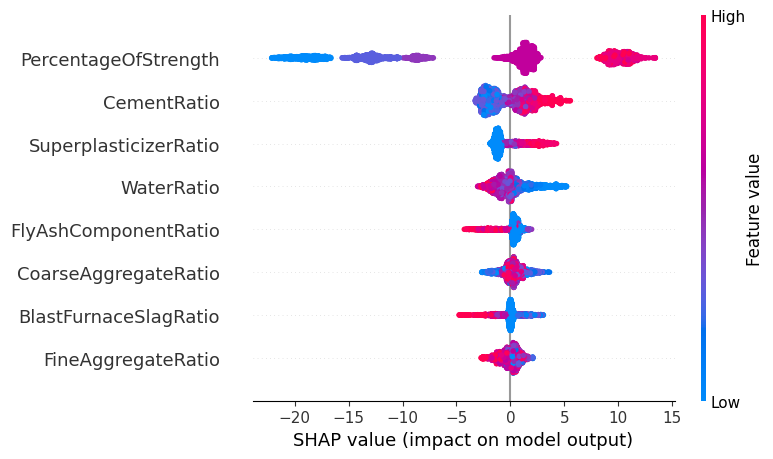

In [103]:
# Создаём объект SHAP
explainer = shap.Explainer(lgb_model, X_train_df)
shap_values = explainer(X_train_df, check_additivity=False)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_train_df)

**PercentageOfStrength**" – самый важный признак.
Находится на вершине списка, значит, вносит наибольший вклад в предсказание.
Низкие значения уменьшают предсказание, а высокие увеличивают.

**CementRatio** – важный признак. Чем больше вяжущего компонента, тем больше прочность. Уменьшение снижает прогноз.

**WaterRatio** - снижает прочность при увеличении.

**SuperplasticizerRatio** - чем больше суперпластификатора, тем сильнее влияет как в плюс, так и в минус. Это говорит о том, что в разных образцах применялся пластификатор для разных целей, поэтому необходима дополнительная информация о типе пластификатора.

**FlyAshComponentRatio** и **BlastFurnaceSlagRatio** - имеют сложное влияние.
Их влияние заметно, но оно варьируется в зависимости от сочетания с другими признаками.
В некоторых случаях они могут увеличивать прочность, в других – уменьшать.

**CoarseAggregateRatio** и **FineAggregateRatio** – наименее значимые.
Их SHAP-значения малы, значит, они не оказывают большого влияния на предсказание модели.
Можно рассмотреть удаление одного из них для упрощения модели.

In [106]:
# Создадим новый датасет и удалим ненужные столбцы
df_new = df.drop(columns=['FineAggregateRatio'])

In [107]:
# Выделяем таргет в отдельную переменную
y = df_new['Strength']

In [108]:
# Выделяем признаки в отельную переменную
X = df_new.drop('Strength', axis=1)

In [109]:
# Нормализуем данные
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [110]:
# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
# Пересчитаем гиперпараметры для LGBM
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2025-02-03 12:44:54,434] A new study created in memory with name: no-name-e1c073d7-48de-4e56-9ab8-24a31c406655
[I 2025-02-03 12:45:00,993] Trial 0 finished with value: 13.742302570926359 and parameters: {'n_estimators': 578, 'max_depth': 12, 'learning_rate': 0.2326458021649503, 'num_leaves': 73, 'min_child_samples': 15, 'subsample': 0.8119561913395386, 'colsample_bytree': 0.8064566445348341, 'reg_alpha': 5.242541431724188, 'reg_lambda': 0.7477955408698544}. Best is trial 0 with value: 13.742302570926359.
[I 2025-02-03 12:45:02,471] Trial 1 finished with value: 12.543917612508723 and parameters: {'n_estimators': 905, 'max_depth': 4, 'learning_rate': 0.12095799399086982, 'num_leaves': 130, 'min_child_samples': 58, 'subsample': 0.9705851514648245, 'colsample_bytree': 0.7616438021842875, 'reg_alpha': 3.6010099168739043, 'reg_lambda': 8.672742201433488}. Best is trial 1 with value: 12.543917612508723.
[I 2025-02-03 12:45:04,078] Trial 2 finished with value: 12.65100118906369 and paramete

In [116]:
# Обучение финальной модели с лучшими гиперпараметрами
best_params = study.best_params
lgb_model = LGBMRegressor(**best_params, verbosity=-1, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.5457234990901827,
              learning_rate=0.026170298836222083, max_depth=6,
              min_child_samples=91, n_estimators=213, n_jobs=-1, num_leaves=36,
              random_state=42, reg_alpha=7.7578900407327005,
              reg_lambda=8.269385481755469, subsample=0.8640881307343946,
              verbosity=-1)

In [117]:
# Предсказания на тестовой выборке
y_pred = lgb_model.predict(X_test)

In [118]:
# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 9.0843
Root Mean Squared Error (RMSE): 11.5394


В результате удаления признака **FineAggregateRatio** удалось немного улучшить значение метрик модели.

# **9. Выводы**

В данной работе проведён полный цикл разработки модели машинного обучения для прогнозирования прочности бетона.

* Проверены дубликаты;

* Проверены пропущенные значения;

* Проведён анализ выбросов;

* Произведена группировка данных и создание новых признаков;

* Проведен разведочный анализ данных (EDA):
    
  * Проанализировано распределение признаков.
  * Построена матрица корреляции для выявления значимых признаков и проверки мультиколлинеарности.

* Выполнена нормализация признаков (где необходимо)

* Проведено тестирование различных моделей регрессии:
  * LinearRegression
  * RandomForestRegressor
  * XGBoost
  * LGBMRegressor

* Проведена оптимизация гиперпараметров с помощью Optuna.

* Оценены метрики (MAE, RMSE)

* Проведен анализ важности признаков с помощью SHAP.


**Общий вывод**

В ходе исследования было выявлено, что наибольшее влияние на прочность бетона оказывают цемент, вода и суперпластификатор.

Проведён анализ данных, который позволил очистить, визуализировать и предобработать их перед обучением моделей.

Были протестированы различные модели, и наилучший результат по метрике RMSE показала градиентный бустинг (LGBMRegressor), особенно после оптимизации гиперпараметров.

Анализ SHAP показал, что некоторые признаки имеют низкую значимость, в результате их исключения удалось немного улучшить показатели метрик.

Итоговое качество модели получилось довольно низкое для задач подобного рода (MAE=9.0843бб RMSE=11.5394), что показывает, в том числе, о необходимсоти увеличения датасета. Кроме того, для улучшения качества модели необходимо запросить важные показатели о температуре твердения бетона, а также о типе используемого пластификатора